## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested. 

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%): 
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


# Integrantes del equipo:

*   Oscar Villa Cardenas - A01794052
*   Diego Alberto Olarte Mira - A01794028
*   Erick Alexei Cambray Servín - A01794243
*   Andres Javier Galindo Vargas - A01793927

### Import libraries

In [1]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch


In [2]:
import numpy as np

#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS

# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

# Neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
import scikitplot as skplt
import gc
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix


In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [4]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)


In [5]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)


In [6]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])


In [7]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))


['welcome', 'to', 'te3007'] [3314, 4, 0]


Test-train split

In [8]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])
print(len(train_dataset), len(val_dataset), len(test_dataset))


108000 12000 7600


Here we can see an example of how the dataloader is packaging the data

In [9]:
for c, tx in train_dataset:
    print(f'Classification: {c} Text: {tx[0:30]}...')


Classification: 2 Text: Story is too good for words Ev...
Classification: 4 Text: Flawed drawings caused spacecr...
Classification: 1 Text: Judge OKs Senate Vacancy Measu...
Classification: 1 Text: Indonesia Confirms Two Women T...
Classification: 1 Text: Thai PM warns of more violence...
Classification: 1 Text: Iraqi Premier and Sunni Leader...
Classification: 2 Text: Tennis: Muster rolls out clay ...
Classification: 1 Text: Britain Agrees to Move Troops ...
Classification: 1 Text: Britain plans tougher laws to ...
Classification: 2 Text: Loss Costs Brazil Top Cup Qual...
Classification: 2 Text: FOOTBALL: TOSHACK: I #39;LL TA...
Classification: 4 Text: Valkyrie Profile and Dragon Qu...
Classification: 3 Text: Brazil to break Aids drug pate...
Classification: 4 Text: BT to offer cheaper Wi-Fi to i...
Classification: 1 Text: Al-Sistani Brokers Disarmament...
Classification: 2 Text: Celebrating human spirit, in a...
Classification: 1 Text: Crackdown Targets New Wave of ...
Classification

In [10]:
def collate_batch(batch, max_words = 25):
    Y, X = list(zip(*batch))
    X = [vocab(tokeniser(text)) for text in X]
    X = [tokens + ([0] * (max_words - len(tokens)))
         if len(tokens) < max_words
         else tokens[: max_words]
        for tokens in X] # Bringing all samples to max_words length.

    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y) - 1 ##We have deducted 1 from target names to get them in range [0,1,2,3] from [1,2,3,4]


In [11]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256


In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)


### Let us build our RNN model

In [13]:
EMBEDDING_SIZE = 50
NEURONS = 50
LAYERS = 1
NUM_CLASSES = 4


In [14]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        self.hidden = hidden
        self.layers = layers

        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden, num_layers=layers, batch_first=True)
                        # You may use PyTorch nn.GRU(), nn.RNN(), or nn.LSTM()

        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        #Pass x to the embeding layer
        embeddings = self.embedding_layer(x)
        #Pass the embedings to the rnn model as well as the number of layers, length of x and neurons
        output, hidden = self.rnn(embeddings, torch.randn(self.layers, len(x), self.hidden))
        #Pass all the rows of the last column to the linear layer and then return the result
        return self.fc(output[:,-1])


In [15]:
loss_fn = nn.CrossEntropyLoss()
def accuracy(model, loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        return accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())


In [16]:
def train(model, optimiser, epochs=100):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()


        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        #CalcValLossAndAccuracy(model, loss_fn, val_loader)


In [17]:
epochs = 15
lr = 1e-3
# instantiate model
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)


In [18]:
train(rnn_model, optimiser=optimiser,  epochs=epochs)


100%|██████████| 422/422 [00:19<00:00, 21.96it/s]


Train Loss : 1.131


100%|██████████| 422/422 [00:18<00:00, 22.47it/s]


Train Loss : 0.641


100%|██████████| 422/422 [00:18<00:00, 22.62it/s]


Train Loss : 0.481


100%|██████████| 422/422 [00:18<00:00, 22.65it/s]


Train Loss : 0.402


100%|██████████| 422/422 [00:18<00:00, 22.87it/s]


Train Loss : 0.353


100%|██████████| 422/422 [00:18<00:00, 22.95it/s]


Train Loss : 0.315


100%|██████████| 422/422 [00:18<00:00, 23.00it/s]


Train Loss : 0.282


100%|██████████| 422/422 [00:18<00:00, 22.53it/s]


Train Loss : 0.260


100%|██████████| 422/422 [00:18<00:00, 22.83it/s]


Train Loss : 0.238


100%|██████████| 422/422 [00:18<00:00, 22.88it/s]


Train Loss : 0.217


100%|██████████| 422/422 [00:18<00:00, 22.77it/s]


Train Loss : 0.200


100%|██████████| 422/422 [00:18<00:00, 22.27it/s]


Train Loss : 0.186


100%|██████████| 422/422 [00:18<00:00, 22.49it/s]


Train Loss : 0.172


100%|██████████| 422/422 [00:18<00:00, 22.46it/s]


Train Loss : 0.160


100%|██████████| 422/422 [00:18<00:00, 22.62it/s]

Train Loss : 0.148


In [19]:
print(f'{accuracy(rnn_model, test_loader):.4f}')


0.8672


In [20]:
max_words = 25
def sample_text(model, loader):
    X_test_text, Y_test = [], []
    for Y, X in test_dataset:
        X_test_text.append(X)
        Y_test.append(Y-1)

    print(X)

    rng = np.random.RandomState(1)
    #Generate a random index
    idx = rng.randint(1, len(X_test_text))
    #Iterate X_test_text and each text will be passed to the tokeniser function and then the result will be passed to the vocab function and an array will be created with the result
    X = [vocab(tokeniser(text)) for text in X_test_text[idx:idx+1]]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
    #Predict the values by passing tensor of x to the model __call__ function also known as the forward function
    preds = rnn_model(torch.tensor(X, dtype=torch.int32))
    #Apply a softmax function to the preds
    preds = F.softmax(preds, dim=-1)

    print("Prediction : ", labels[preds.argmax()])
    print("Actual :     ", labels[Y_test[idx]])


In [21]:
sample_text(rnn_model, test_loader)


EBay gets into rentals EBay plans to buy the apartment and home rental service Rent.com for \$415 million, adding to its already exhaustive breadth of offerings.
Prediction :  Business
Actual :      Business


In [22]:
# create confusion matrix
Y_shuffled, Y_preds = [], []
for X, Y in test_loader:
    preds = rnn_model(X)
    Y_preds.append(preds)
    Y_shuffled.append(Y)
gc.collect()
Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

Y_actual, Y_preds = Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

print(confusion_matrix(Y_actual, Y_preds))


[[1677   49  105   69]
 [  98 1728   29   45]
 [ 100   13 1599  188]
 [  76   25  202 1597]]


Confusion Matrix

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

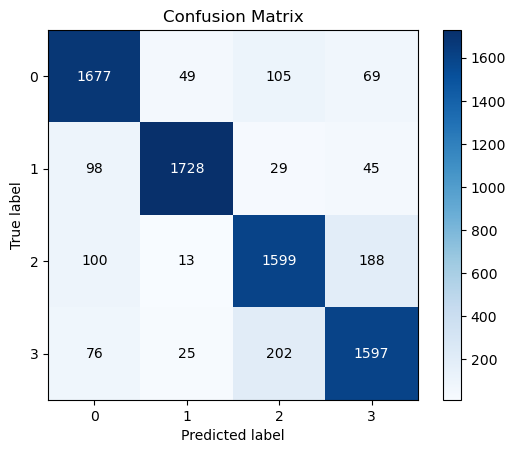

In [23]:
skplt.metrics.plot_confusion_matrix(Y_actual, Y_preds)
